In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

EXP_NAME = "autoencoder-paraphrase"
PROJECT_ROOT = "/home/jovyan/vmeshchaninov/HierarchicalDiffusion"
EXP_RESULT_PATH = f"{PROJECT_ROOT}/experiments/results/{EXP_NAME}/"
os.makedirs(EXP_RESULT_PATH, exist_ok=True)
sys.path.append(PROJECT_ROOT)
os.environ["PROJECT_ROOT"] = PROJECT_ROOT

In [3]:
import torch
import hydra
from omegaconf import DictConfig, OmegaConf
from hydra.core.global_hydra import GlobalHydra

from encoder_trainer import EncoderTrainer

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import rel_entr  # KL divergence computation

/home/jovyan/.mlspace/envs/dif_env_v2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reset Hydra to avoid conflicts if already initialized
GlobalHydra.instance().clear()

# Initialize Hydra and load config manually
hydra.initialize(config_path="../conf", version_base=None)  # Set path to your configs

# Load the configuration
cfg = hydra.compose(config_name="config")  # Replace with your main config file

# Print the loaded config
print(OmegaConf.to_yaml(cfg))

autoencoder:
  optimizer:
    name: stableadam
    learning_rate: 0.0002
    warmup_lr: 1.0e-08
    min_lr: 0.0001
    weight_decay: 1.0e-05
    eps: 1.0e-06
    betas:
    - 0.9
    - 0.98
    linear_warmup: 1000
    grad_clip_norm: 10.0
  model:
    checkpoints_prefix: autoencoder
    text_encoder: bert-base-cased
    text_encoder_freeze_params: true
    num_workers: 30
    load_checkpoint: null
    enc_path: null
  latent:
    dim: 768
    resolutions:
    - 1
    - 1
    - 2
    - 4
  hidden:
    size: 768
  loss:
    level_weights:
    - 1.0
    - 1.0
    - 1.0
    - 1.0
  training:
    training_iters: 50000
    batch_size: 512
    batch_size_per_gpu: 512
  params:
    text_encoder: 0
    encoder: 0
    decoder: 0
    total: 0
  all_params: dict()
  logging:
    log_freq: 10
    eval_freq: 10000
encoder:
  attention:
    head_size: 64
    num_heads: 12
    probs_dropout: 0.0
    qk_norm: true
    implementation: flash_attention_2
  embedding:
    dim: 768
    max_position_embeddin

/home/jovyan/.mlspace/envs/dif_env_v2/lib/python3.11/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [5]:

from datasets import Dataset, load_from_disk

In [6]:
# Setup the config
cfg.ddp.enabled = False
cfg.autoencoder.model.load_checkpoint = "./autoencoderlatent_dim=768-latent_resolutions=[1, 1, 2, 4]-bert_model=bert-base-cased-text_encoder_freeze_params=True-level_weights=[1.0, 1.0, 1.0, 1.0]-bert_masking=True/40000.pth"


In [8]:
trainer = EncoderTrainer(cfg)

/home/jovyan/.mlspace/envs/dif_env_v2/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/jovyan/vmeshchaninov/HierarchicalDiffusion/encoder_trainer.py:301: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary o

Checkpotint ./autoencoderlatent_dim=768-latent_resolutions=[1, 1, 2, 4]-bert_model=bert-base-cased-text_encoder_freeze_params=True-level_weights=[1.0, 1.0, 1.0, 1.0]-bert_masking=True/40000.pth loaded


/home/jovyan/vmeshchaninov/HierarchicalDiffusion/encoder_trainer.py:215: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  def _setup_train_data_generator(self) -> None:
/home/jovyan/vmeshchaninov/HierarchicalDiffusion/encoder_trainer.py:286: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend 

Checkpotint ./autoencoderlatent_dim=768-latent_resolutions=[1, 1, 2, 4]-bert_model=bert-base-cased-text_encoder_freeze_params=True-level_weights=[1.0, 1.0, 1.0, 1.0]-bert_masking=True/40000.pth loaded


In [10]:
path_to_data = f"{PROJECT_ROOT}/data/en_wiki_paraphrase"
data = load_from_disk(path_to_data)

In [11]:
data.column_names

['anchor',
 'positive',
 'positive_score',
 'hard_negative_1',
 'hard_negative_score_1',
 'hard_negative_2',
 'hard_negative_score_2']

In [12]:
def get_latent(text):
    tokenized = trainer.tokenizer(
        text,
        add_special_tokens=True,
        padding=True,
        truncation=True,
        max_length=trainer.cfg.dataset.max_sequence_len,
        return_tensors="pt",
        return_attention_mask=True,
        return_token_type_ids=False,
    ).to(device)

    with torch.autocast(device_type='cuda', dtype=torch.bfloat16), torch.no_grad():
        latents = trainer.encoder(token_ids=tokenized["input_ids"], mask_tokens=tokenized["attention_mask"])
    return latents, tokenized


In [ ]:
latent, tokenized = get_latent(data["anchor"])

print(latent.shape)

torch.Size([10000, 8, 768])


/home/jovyan/.mlspace/envs/dif_env_v2/lib/python3.11/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


In [19]:
latent.mean(dim=0)

tensor([[ 0.1920,  0.6462, -0.1106,  ..., -0.1756, -0.3116,  0.3221],
        [-0.2595,  0.0559,  0.2472,  ..., -0.2992,  0.1662,  0.2706],
        [-0.5680,  0.2027, -0.6451,  ..., -0.9619,  0.3796,  1.2550],
        ...,
        [-0.1474, -0.0019,  0.6934,  ...,  0.3008, -0.4152, -0.6913],
        [ 0.0434,  0.6120, -0.1385,  ..., -0.3313,  0.0220,  0.7733],
        [ 0.1704,  0.2951,  1.2670,  ...,  0.4809, -0.5355, -0.8067]],
       device='cuda:0')

In [14]:
latent.std(dim=0)

tensor([[0.8373, 0.8472, 0.8223,  ..., 0.8419, 0.8337, 0.8340],
        [0.8762, 0.9001, 0.8438,  ..., 0.9373, 0.9543, 0.8898],
        [0.5329, 0.5515, 0.5541,  ..., 0.6027, 0.6011, 0.5707],
        ...,
        [0.7466, 0.6993, 0.7375,  ..., 0.8250, 0.8074, 0.7529],
        [0.7634, 0.7105, 0.7634,  ..., 0.7968, 0.8157, 0.7769],
        [0.6632, 0.5925, 0.6480,  ..., 0.7261, 0.7003, 0.6203]],
       device='cuda:0')

In [15]:
latent.std(dim=0).mean()

tensor(0.7442, device='cuda:0')

In [16]:
latent.std(dim=0).min()

tensor(0.5079, device='cuda:0')

In [17]:
latent.std(dim=0).max()

tensor(1.3270, device='cuda:0')

In [18]:
latent.std(dim=0).median()

tensor(0.7551, device='cuda:0')

In [169]:
positive_texts = data["positive"]
negative_texts = []
for i in range(len(positive_texts)):
    random_index = i
    while i == random_index:
        random_index = np.random.randint(0, len(positive_texts))

    negative_texts.append(positive_texts[random_index])

negative_latent, negative_tokenized = get_latent(negative_texts)

In [170]:
def cosine(a, b):
    a = a / torch.norm(a, dim=1, p=2)[:, None]
    b = b / torch.norm(b, dim=1, p=2)[:, None]
    return torch.sum(a * b, dim=1)

In [171]:
num_samples = anchor_latent.shape[0]

with torch.autocast(device_type='cuda', dtype=torch.bfloat16), torch.no_grad():
    positive_scores = (cosine(anchor_latent.reshape(num_samples, -1), positive_latent.reshape(num_samples, -1)) * 100.).detach().cpu()
    hard_negative_scores = (cosine(anchor_latent.reshape(num_samples, -1), hard_negative_latent.reshape(num_samples, -1)) * 100.).detach().cpu()
    negative_scores = (cosine(anchor_latent.reshape(num_samples, -1), negative_latent.reshape(num_samples, -1)) * 100.).detach().cpu()

In [172]:
def KL_divergence(positive_scores, negative_scores, bins):
    # Compute histograms
    positive_hist, _ = np.histogram(positive_scores, bins=bins, density=True)
    negative_hist, _ = np.histogram(negative_scores, bins=bins, density=True)

    # Avoid zero probabilities by adding a small constant (epsilon)
    epsilon = 1e-10
    positive_hist += epsilon
    negative_hist += epsilon

    # Compute KL divergence (P || Q)
    kl_div = np.sum(rel_entr(positive_hist, negative_hist))

    return kl_div

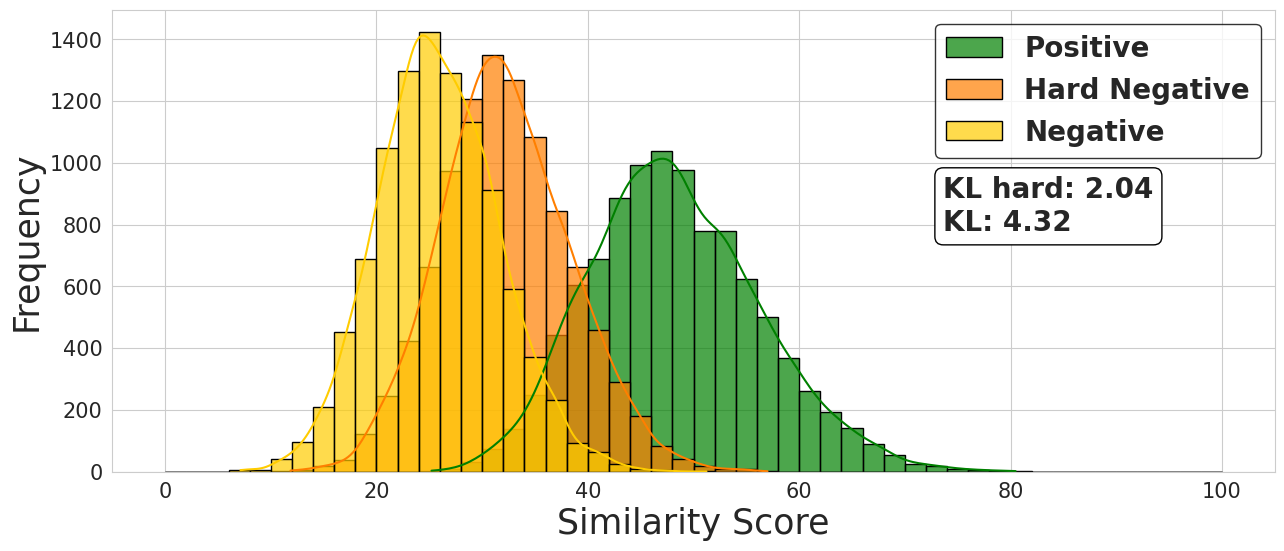

In [173]:
# Set the style for an awesome look
sns.set_style("whitegrid")
plt.figure(figsize=(15, 6))

font_size = 20
num_bins = 50
bins = np.linspace(0, 100, num_bins + 1)

# Plot histograms
sns.histplot(positive_scores, bins=bins, kde=True, color="green", label="Positive", alpha=0.7, edgecolor="black")
sns.histplot(hard_negative_scores, bins=bins, kde=True, color="#FF7F00", label="Hard Negative", alpha=0.7, edgecolor="black")
sns.histplot(negative_scores, bins=bins, kde=True, color="#FFCC00", label="Negative", alpha=0.7, edgecolor="black")

# Add title and labels with a creative touch
# Title with colored text
# plt.title("Positivity vs Negativity: A Histogram of Contrasts", fontsize=font_size + 10, fontweight="bold", pad=15)

plt.xlabel("Similarity Score", fontsize=font_size + 5)
plt.ylabel("Frequency", fontsize=font_size + 5)

# Adjust tick sizes
plt.xticks(fontsize=font_size - 5)
plt.yticks(fontsize=font_size - 5)

# Add legend
legend = plt.legend(frameon=True, loc="upper right", prop={'weight': 'bold', 'size': font_size}, edgecolor="black")  # Positioned at the upper right with bold text

# Get legend position
legend_bbox = legend.get_window_extent().transformed(plt.gcf().dpi_scale_trans.inverted())

# Add KL Divergence text below the legend
kl_hard = KL_divergence(positive_scores, hard_negative_scores, bins)
kl = KL_divergence(positive_scores, negative_scores, bins)

plt.gcf().text(
    (plt.gcf().dpi_scale_trans.get_matrix()[0, 0] - legend_bbox.x0 - 22) / plt.gcf().dpi_scale_trans.get_matrix()[0, 0],
    (plt.gcf().dpi_scale_trans.get_matrix()[1, 1] - legend_bbox.y0 - 45) / plt.gcf().dpi_scale_trans.get_matrix()[1, 1],  # Match legend x position
    f"KL hard: {kl_hard:.2f}\n" + f"KL: {kl:.2f}",
    fontsize=font_size, fontweight="bold", 
    bbox=dict(facecolor="white", alpha=1.0, edgecolor="black", boxstyle="round")
)


# Save as PDF
plt.savefig(f"{PROJECT_ROOT}/experiments/results/{EXP_NAME}/histogram.pdf", format="pdf", bbox_inches="tight")

# Show the plot
plt.show()

In [174]:
import json

result = {
    "positive_scores": positive_scores.tolist(),
    "hard_negative_scores": hard_negative_scores.tolist(),
    "negative_scores": negative_scores.tolist(),
    "kl_hard": kl_hard,
    "kl": kl,
}
json.dump(result, open(f"{PROJECT_ROOT}/experiments/results/{EXP_NAME}/result.json", "w"), indent=4)